# day 3-2

このノートブックの実行例は[こちら(HTML版)](lecture-gssm2025/notebooks-sample/day-3-2.html)で確認できます

---

## 0. 準備

### 0.1 必要なパッケージのインストール

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y automake autoconf perl libtool
!sudo autoreconf -f -i

教材のダウンロード

In [ ]:
!git clone https://github.com/haradatm/lecture-gssm2025

In [ ]:
!ln -s lecture-gssm2025/notebooks/gssm_utils.py .

### 0.2 MeCab インストール

In [ ]:
!bash lecture-gssm2025/scripts/install_mecab.sh >> install_mecab.log 2>&1
!tail -n 1 install_mecab.log

### 0.3 CaboCha インストール

In [ ]:
!bash lecture-gssm2025/scripts/install_cabocha.sh >> install_cabocha.log 2>&1
!tail -n 1 install_cabocha.log

### 0.4 セッションの再起動

In [ ]:
import os
os.kill(os.getpid(), 9)

### 0.5 動作確認

In [1]:
import MeCab
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc")
print(tagger.parse("今日はいい天気です"))

今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



In [2]:
import CaboCha
cp = CaboCha.Parser("-r ./tools/usr/local/etc/cabocharc")
tree = cp.parse("今日はいい天気です")
print(tree.toString(CaboCha.FORMAT_LATTICE))

* 0 2D 0/1 -1.041733
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.041733
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
* 2 -1D 0/1 0.000000
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



## 1. テキスト解析 (2)
### KHCoder のテキスト解析&分析

### 1.0 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [5]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

### 1.1 データのダウンロード (前回ダウンロード済みのためスキップ)

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2024-2025.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2024/1~2025 GW明け | 本講義の全体を通して使用する |

In [ ]:
# rakuten-1000-2024-2025.xlsx.zip をダウンロードする
FILE_ID = "1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS"
!gdown {FILE_ID}
!unzip -o rakuten-1000-2024-2025.xlsx.zip

### 1.2 データの読み込み (DataFrame型)

In [7]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2024-2025.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 19)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別,投稿日
0,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,わんこと泊まれて良かった！,3,3,3,3,3.0,4.0,3.0,レジャー,家族,45413,投稿者,na,na,45445.668553
1,A_レジャー,01_登別,9691,登別温泉 ホテルゆもと登別,古い建物ですがきれいにしている感じでした。入った瞬間においが気になりましたが、タバコのにおい...,5,5,5,4,5.0,4.0,5.0,レジャー,家族,45474,mamemama3,40代,女性,45499.742442
2,A_レジャー,01_登別,40708,虎杖浜温泉 ホテル いずみ,3月15日に初めて宿泊させて頂きました。予約プランは和室6畳でしたが、空きがあるとのことで1...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,45717,ハコ9437,40代,女性,45733.810486
3,A_レジャー,01_登別,139962,ザ レイクビュー ＴＯＹＡ 乃の風リゾート,大きめ柴犬と宿泊しましたが、部屋は充分な広さでした夕朝食のブッフェも、種類豊富で美味しかった...,4,5,5,4,4.0,4.0,5.0,レジャー,家族,45413,投稿者,na,na,45440.662477
4,A_レジャー,01_登別,168374,虎杖浜天然温泉 「旅人の湯」ホテルルートインＧｒａｎｄ室蘭,コーヒー無料サービスが嬉しい。水のペットボトルサービスがあるとさらに良い（最近デフォルトのビ...,4,3,4,4,3.0,3.0,NaN,ビジネス,一人,45505,投稿者,na,na,45529.484410


### 1.3 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [8]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(151591, 6)


,文書ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,わん,名詞,A_レジャー,01_登別,"(わん, 名詞)"
1,1,良い,形容詞,A_レジャー,01_登別,"(良い, 形容詞)"
2,2,古い,形容詞,A_レジャー,01_登別,"(古い, 形容詞)"
3,2,建物,名詞,A_レジャー,01_登別,"(建物, 名詞)"
4,2,きれいだ,形容動詞,A_レジャー,01_登別,"(きれいだ, 形容動詞)"


抽出語の出現頻度をカウントする

In [9]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]

# DataFrame を表示する
word_counts_df = pd.DataFrame(word_list, columns=columns)
print(word_counts_df.shape)
display(word_counts_df.head(10))

(8746, 4)


,単語ID,表層,出現頻度,dict_key
0,0,部屋,6363,"(部屋, 名詞)"
1,1,良い,5242,"(良い, 形容詞)"
2,2,ホテル,2792,"(ホテル, 名詞)"
3,3,風呂,2688,"(風呂, 名詞)"
4,4,美味しい,2290,"(美味しい, 形容詞)"
5,5,ない,2176,"(ない, 形容詞)"
6,6,温泉,1836,"(温泉, 名詞)"
7,7,スタッフ,1623,"(スタッフ, 名詞)"
8,8,立地,1434,"(立地, 名詞)"
9,9,よい,1411,"(よい, 形容詞)"


単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [10]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# DataFrame を表示する
# print(docs_150_df.shape)
display(docs_150_df)

,文書ID,単語ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,1,良い,形容詞,A_レジャー,01_登別,"(良い, 形容詞)"
1,2,39,古い,形容詞,A_レジャー,01_登別,"(古い, 形容詞)"
2,2,75,建物,名詞,A_レジャー,01_登別,"(建物, 名詞)"
3,2,59,きれいだ,形容動詞,A_レジャー,01_登別,"(きれいだ, 形容動詞)"
4,2,27,感じ,名詞,A_レジャー,01_登別,"(感じ, 名詞)"
...,...,...,...,...,...,...,...
84213,10000,25,気,名詞,B_ビジネス,10_福岡,"(気, 名詞)"
84214,10000,3,風呂,名詞,B_ビジネス,10_福岡,"(風呂, 名詞)"
84215,10000,0,部屋,名詞,B_ビジネス,10_福岡,"(部屋, 名詞)"
84216,10000,40,人,名詞,B_ビジネス,10_福岡,"(人, 名詞)"


「文書-抽出語」表 を作成する

In [11]:
# 「単語出現回数」 表から出現回数Top 75語のみ抽出する
word_counts_75_df = word_counts_df[0:75]

# 「文書-抽出語」 表も出現回数Top 75語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_75_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_75_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_75_df = pd.crosstab(
    [
        docs_75_df['カテゴリー'], 
        docs_75_df['エリア'], 
        docs_75_df['文書ID']
    ], 
    docs_75_df['単語ID'], margins=False
)
cross_75_df.columns = word_counts_75_df["表層"]

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9621, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   4    1   0     0   1   1     1   0   0  ...   0   0   
             4       2   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   2    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     3   0   0  ...   0   0   
             9999    1   1    1   2     0   1   0     0   0   0  ...   0   0   
             10000   2   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  少ない  女性  楽しい  安い  ルーム  水  十分だ  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0   0    0   0    0  0    0  
             2          0    0   0    0   0    0  0    0  
             3          0    0   0    0   0    0  0    0  
             4          0    0   0    1   0    0  0    0  
             5          0    0   0    0   0    0  1    0  
...                   ...  ...  ..  ...  ..  ... ..  ...  
B_ビジネス 10_福岡 9996       0    0   0    0   0    0  3    0  
             9997       0    0   0    0   0    0  0    0  
             9998       0    0   0    0   0    0  0    0  
             9999       0    0   0    0   0    0  0    0  
             10000      0    0   0    0   0    0  0    0  

[9621 rows x 75 columns]

「文書-抽出語」 表を {0,1} に変換する

In [12]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_75_df[cross_75_df > 0] = 1

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9621, 75)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  お湯  徒歩  \
カテゴリー  エリア   文書ID                                                ...           
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...   0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...   0   1   
             3       1   1    1   0     0   1   1     1   0   0  ...   0   0   
             4       1   0    0   0     1   0   0     0   0   0  ...   0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...   0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ...  ..  ..   
B_ビジネス 10_福岡 9996    0   1    0   0     0   0   0     0   0   0  ...   0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...   0   0   
             9998    1   1    0   0     0   0   0     1   0   0  ...   0   0   
             9999    1   1    1   1     0   1   0     0   0   0  ...   0   0   
             10000   1   0    1   1     0   0   0     0   0   0  ...   0   1   

表層                  ありがたい  少ない  女性  楽しい  安い  ルーム  水  十分だ  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1          0    0   0    0   0    0  0    0  
             2          0    0   0    0   0    0  0    0  
             3          0    0   0    0   0    0  0    0  
             4          0    0   0    1   0    0  0    0  
             5          0    0   0    0   0    0  1    0  
...                   ...  ...  ..  ...  ..  ... ..  ...  
B_ビジネス 10_福岡 9996       0    0   0    0   0    0  1    0  
             9997       0    0   0    0   0    0  0    0  
             9998       0    0   0    0   0    0  0    0  
             9999       0    0   0    0   0    0  0    0  
             10000      0    0   0    0   0    0  0    0  

[9621 rows x 75 columns]

### 1.4 共起ネットワーク

共起度行列を作成する (抽出語-抽出語)

In [14]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

# 共起行列を作成する
X = cross_75_df.values
X = csc_matrix(X)
Xc = (X.T * X)
# 対角成分のみにする
Xc = np.triu(Xc.toarray())

# DataFrame 型に整える
cooccur_75_df = pd.DataFrame(Xc, columns=cross_75_df.columns, index=cross_75_df.columns)

# DataFrame を表示する
print(cooccur_75_df.shape)
display(cooccur_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,美味しい,ない,温泉,スタッフ,立地,よい,...,お湯,徒歩,ありがたい,少ない,女性,楽しい,安い,ルーム,水,十分だ
表層,,,,,,,,,,,,,,,,,,,,,
部屋,4390,1877,1032,1267,1055,989,708,777,666,655,...,191,170,179,187,145,175,151,159,176,213
良い,0,3703,873,1000,889,689,682,694,758,329,...,164,160,116,139,138,115,126,120,122,123
ホテル,0,0,1996,438,380,477,277,358,353,257,...,58,109,81,94,88,69,87,98,68,87
風呂,0,0,0,2142,634,513,366,363,301,344,...,154,86,84,103,80,90,67,54,96,94
美味しい,0,0,0,0,2023,360,469,420,247,281,...,101,76,67,107,60,113,43,43,59,50


#### (a) 共起ネットワーク (共起度の高いエッジを残す)

<Figure size 800x800 with 0 Axes>

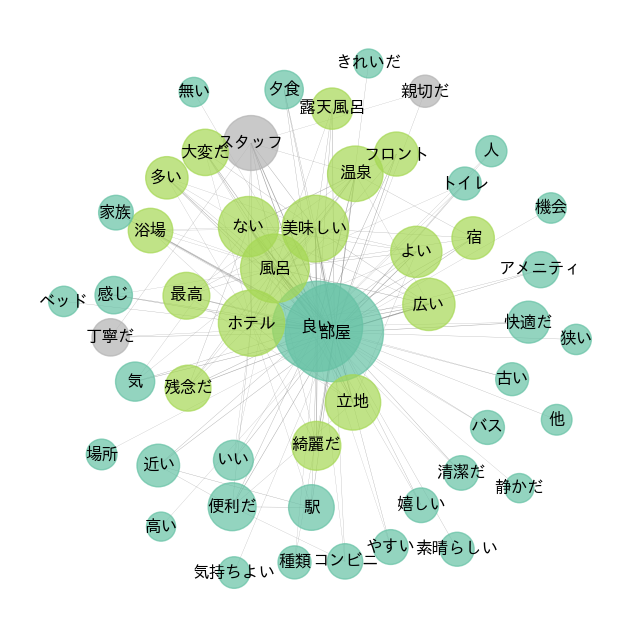

In [17]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(共起度)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(cooccur_75_df, word_counts, cooccur_75_df.values.max() * 0.05)

#### (b) 共起ネットワーク (Jaccard 係数が上位のエッジを残す)

pyvis.html


<Figure size 800x800 with 0 Axes>

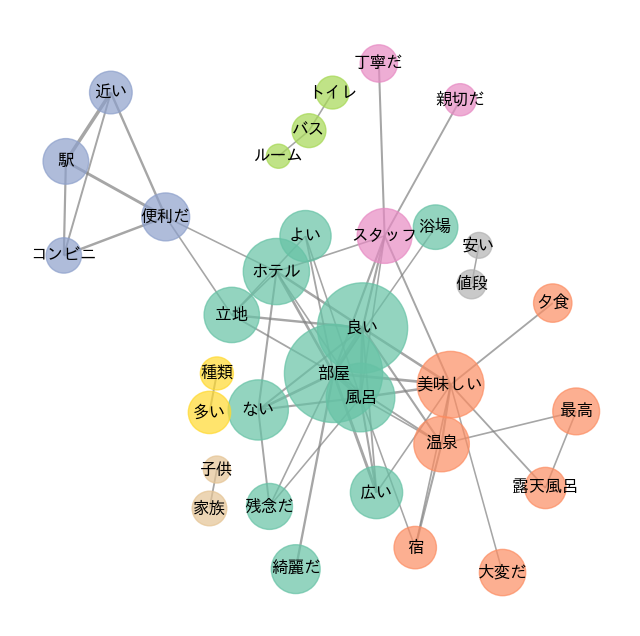

In [18]:
# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_75_df = gssm_utils.jaccard_coef(cooccur_75_df, cross_75_df)

# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(Jaccard係数)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(jaccard_75_df, word_counts, np.sort(jaccard_75_df.values.reshape(-1))[::-1][60], pyvis=True)

### 1.5 対応分析

「文書-抽出語」 表を確認する

In [ ]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

「外部変数-抽出語」 クロス集計表を作成する

In [ ]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_75_df = pd.concat(
    [
        cross_75_df.groupby(level='カテゴリー').sum(), 
        cross_75_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_75_df.shape)
display(aggregate_75_df)

#### (a) 対応分析プロット (ライブラリ mca を使用)

In [ ]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_75_df.shape[1]
mca_ben = mca.MCA(aggregate_75_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (b) 対応分析プロット (カイ2乗値を手計算してプロットする)

In [ ]:
table_N = aggregate_75_df.values
row_sum = table_N.sum(axis=1)
col_sum = table_N.sum(axis=0)
n = aggregate_75_df.values.sum()

# カイ2乗値を求める
expected = np.outer(row_sum, col_sum) / n
chisq = np.square(table_N - expected) / expected
residuals = (table_N - expected) / np.sqrt(expected)

# Standardized residuals
residuals = residuals / np.sqrt(n)

# Number of dimensions
nb_axes = min(residuals.shape[0]-1, residuals.shape[1]-1)

# Singular value decomposition
U, s, V = np.linalg.svd(residuals, full_matrices=True)
sv = s[:nb_axes]
u = U[:, :nb_axes]
v = V[:nb_axes, :]

# row mass
row_mass = row_sum / n

# row coord = u * sv /sqrt(row.mass)
row_coord = (u * sv) / np.sqrt(row_mass)[:, np.newaxis]

# col mass
col_mass = col_sum / n

# row coord = sv * vT /sqrt(col.mass)
col_coord = (sv * v.T) / np.sqrt(col_mass)[:, np.newaxis]

# 固有値を求める
eige_nvalue = s ** 2

# 寄与率を求める
explained_inertia = 100 * eige_nvalue / sum(eige_nvalue)

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (c) 対応分析プロット (共起頻度のままプロットする)

In [ ]:
import numpy as np

table_N = aggregate_75_df.values
table_P = table_N / aggregate_75_df.values.max()

# Singular value decomposition
U, s, V = np.linalg.svd(table_P, full_matrices=True)
sv = s[:nb_axes]
u = U[:, :nb_axes]
v = V[:nb_axes, :]

# row mass
row_mass = row_sum / n

# row coord = u * sv /sqrt(row.mass)
row_coord = (u * sv) / np.sqrt(row_mass)[:, np.newaxis]

# col mass
col_mass = col_sum / n

# row coord = sv * vT /sqrt(col.mass)
col_coord = (sv * v.T) / np.sqrt(col_mass)[:, np.newaxis]

# 固有値を求める
eige_nvalue = s ** 2

# 寄与率を求める 
explained_inertia = 100 * eige_nvalue / sum(eige_nvalue)

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord,row_labels, col_labels, explained_inertia)

#### (d) PCAプロット (共起頻度のままプロットする)

In [ ]:
# 必要ライブラリのインポート
from sklearn.decomposition import PCA

table_N = aggregate_75_df.values

# ライブラリ PCA による主成分分析
pca = PCA()

reduced = pca.fit_transform(table_N.T)
coeff = np.transpose(pca.components_)
var_ratio = pca.explained_variance_ratio_

scalex = 1.0 / (reduced[:,0].max() - reduced[:,0].min())
scaley = 1.0 / (reduced[:,1].max() - reduced[:,1].min())
reduced[:,0] *= scalex
reduced[:,1] *= scaley

# プロットする
gssm_utils.plot_pca(coeff, reduced, row_labels, col_labels, var_ratio)

#### (e) PCAプロット (カイ2乗値をプロットする)

In [ ]:
# 必要ライブラリのインポート
from sklearn.decomposition import PCA

import numpy as np

table_N = aggregate_75_df.values
row_sum = table_N.sum(axis=1)
col_sum = table_N.sum(axis=0)
n = aggregate_75_df.values.sum()

# カイ2乗値を求める
expected = np.outer(row_sum, col_sum) / n
chisq = np.square(table_N - expected) / expected
residuals = (table_N - expected) / np.sqrt(expected)

# Standardized residuals
residuals = residuals / np.sqrt(n)

# ライブラリ PCA による主成分分析
pca = PCA()

reduced = pca.fit_transform(residuals.T)
coeff = np.transpose(pca.components_)
var_ratio = pca.explained_variance_ratio_

scalex = 1.0 / (reduced[:,0].max() - reduced[:,0].min())
scaley = 1.0 / (reduced[:,1].max() - reduced[:,1].min())
reduced[:,0] *= scalex
reduced[:,1] *= scaley

# プロットする
gssm_utils.plot_pca(coeff, reduced, row_labels, col_labels, var_ratio)

---

## 【演習】 2021~2022 データセット 

### 2.0 【演習】 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [ ]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

### 2.1 【演習】 データのダウンロード

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2021-2022.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2021/1~2022/12 | 演習用 (年度で比較する場合など) |

In [ ]:
# rakuten-1000-2021-2022.xlsx.zip をダウンロードする
FILE_ID = "1ru2f4vasZBDo6Rt1B9OwMN-eksyqAl7i"
!gdown --id {FILE_ID}
!unzip -o rakuten-1000-2021-2022.xlsx.zip

### 2.2 【演習】 データの読み込み (DataFrame型)

In [ ]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2021-2022.xlsx")
print(all_df.shape)
display(all_df.head())

### 2.3 【演習】 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [ ]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

抽出語の出現頻度をカウントする

In [ ]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [ ]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

「文書-抽出語」表 を作成する

In [ ]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

「文書-抽出語」 表を {0,1} に変換する

In [ ]:
# ToDo: 1.3 の該当コードをコピーして貼り付けて実行してください

### 2.4 【演習】 共起ネットワーク

共起度行列を作成する (抽出語-抽出語)

In [ ]:
# ToDo: 1.4 の該当コードをコピーして貼り付けて実行してください

#### (b) 共起ネットワーク (Jaccard 係数が上位のエッジを残す)

In [ ]:
# ToDo: 1.4 (b) の該当コードをコピーして貼り付けて実行してください

### 2.5 【演習】 対応分析

「文書-抽出語」 表を確認する

In [ ]:
# ToDo: 1.5 の該当コードをコピーして貼り付けて実行してください

「外部変数-抽出語」 クロス集計表を作成する

In [ ]:
# ToDo: 1.5 の該当コードをコピーして貼り付けて実行してください

#### (a) 対応分析プロット (ライブラリ mca を使用)

In [ ]:
# ToDo: 1.5 (a)のコードをコピーして貼り付けて実行してください